# Recurrent PPO landing using raw altimeter readings

In [1]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Mars3dof_env')
sys.path.append('../../../Mars_DTM')
%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/PCM/PCM_v3/Projects/AAS-19-293/Mars_landing_DTM


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

Quaternion_attitude
(10500, 8000) 0.0 382.8380000000001
DTM MM: nref fixed:  384 10500 8000
3-dof dynamics model
lander model apf
queue fixed
Flat Constraint


<IPython.core.display.Javascript object>


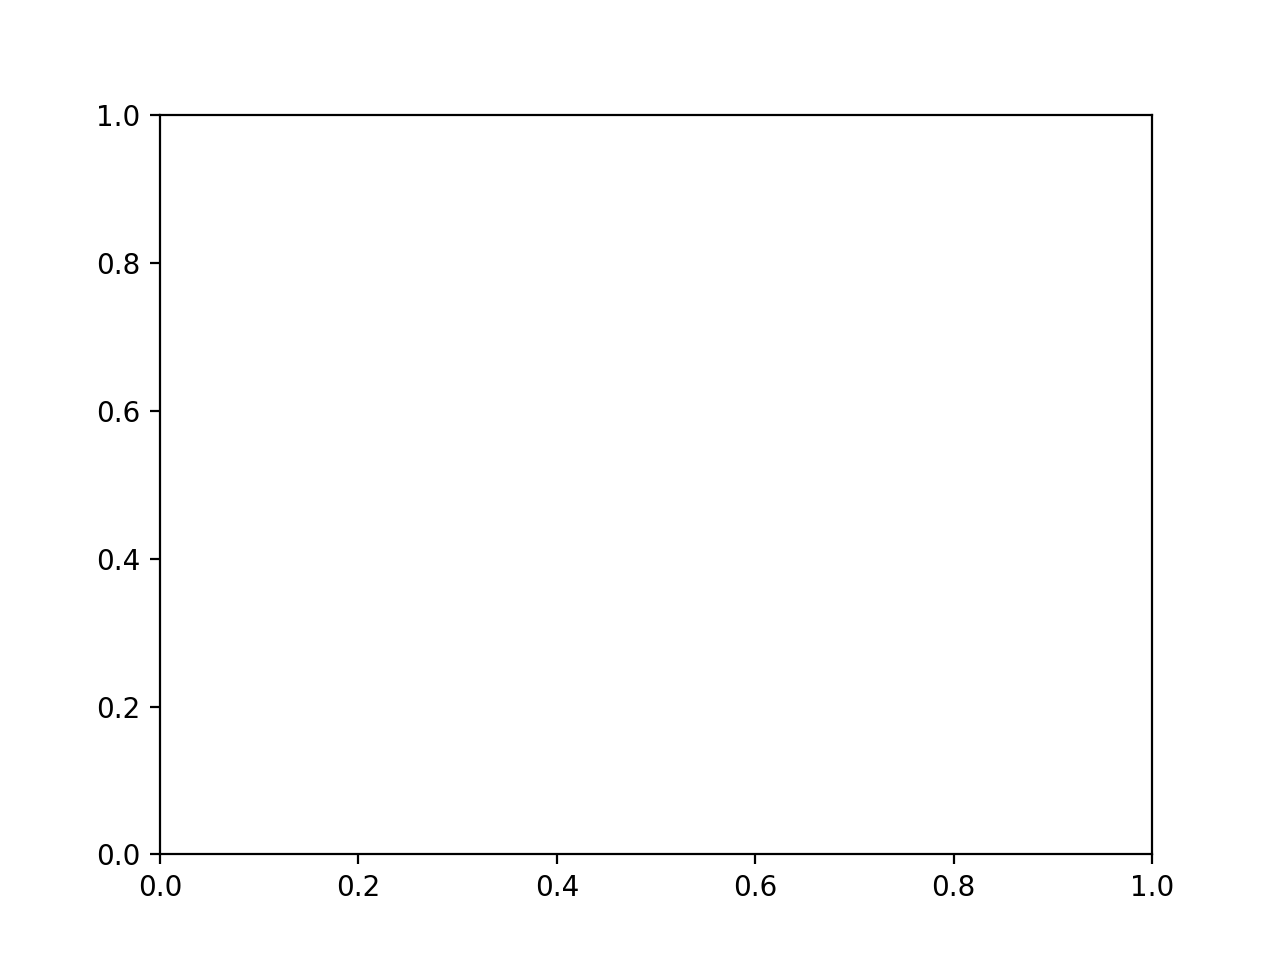

<IPython.core.display.Javascript object>


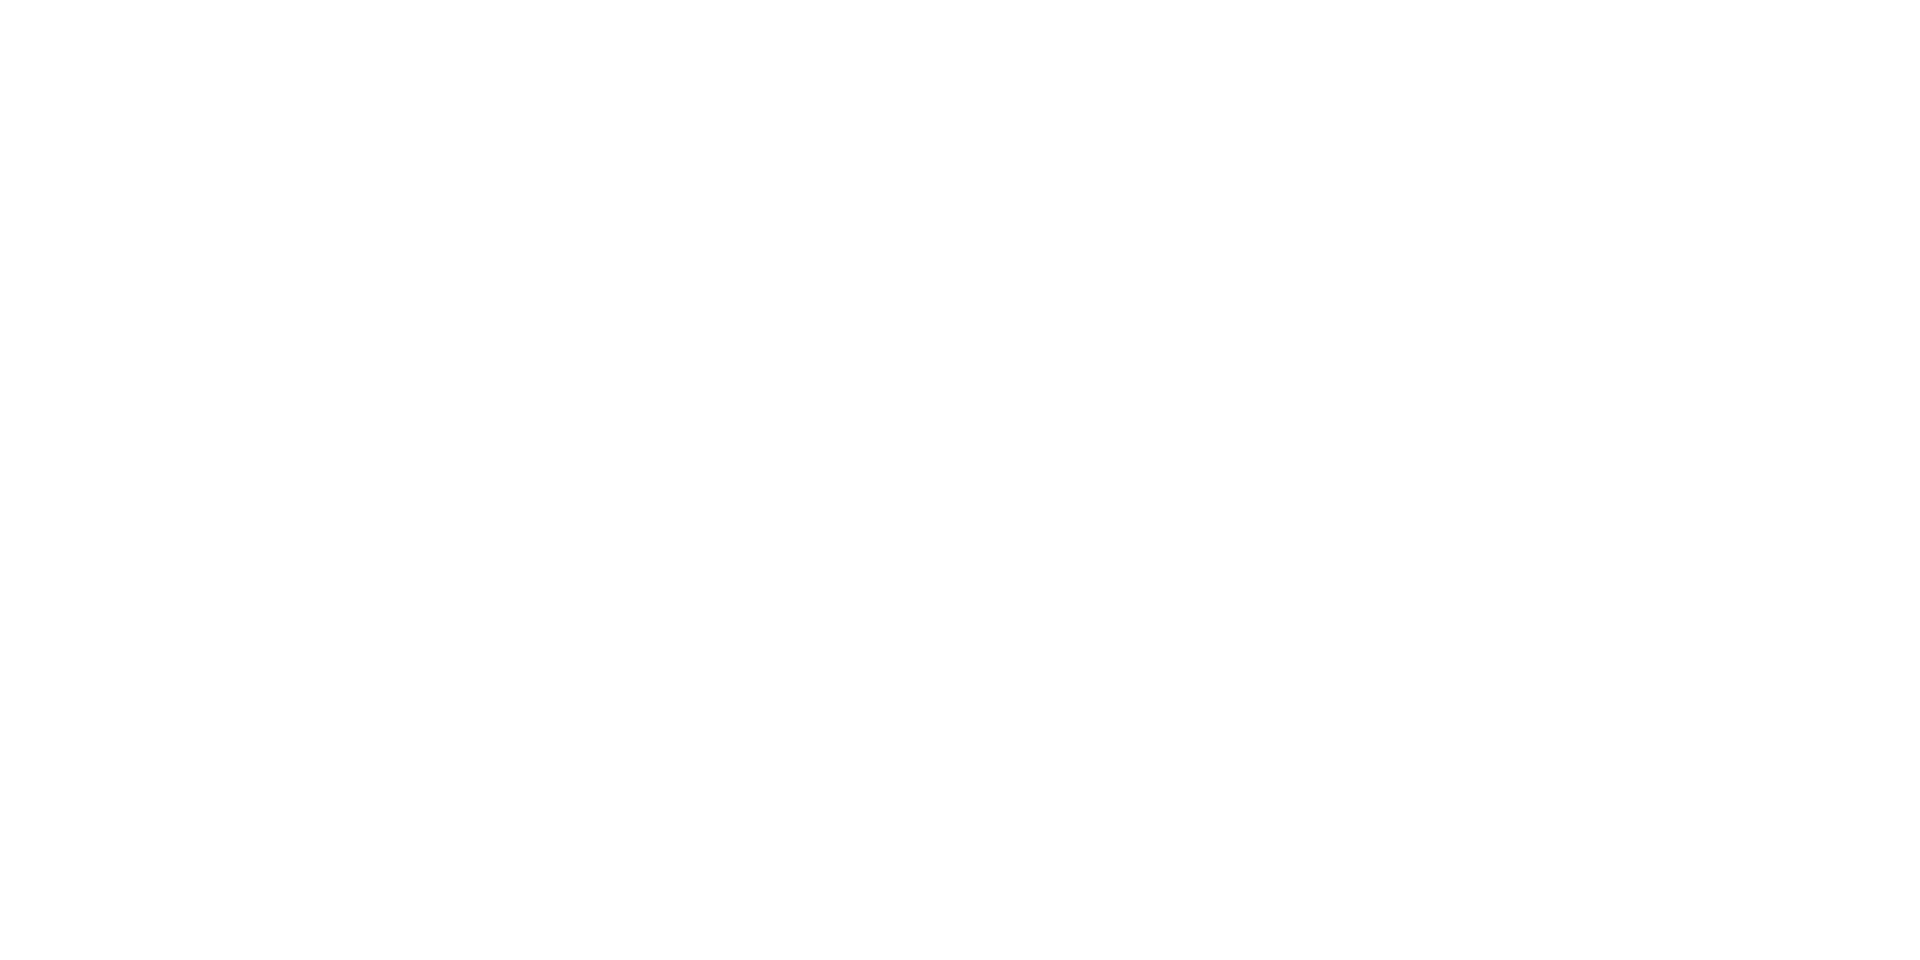

<IPython.core.display.Javascript object>


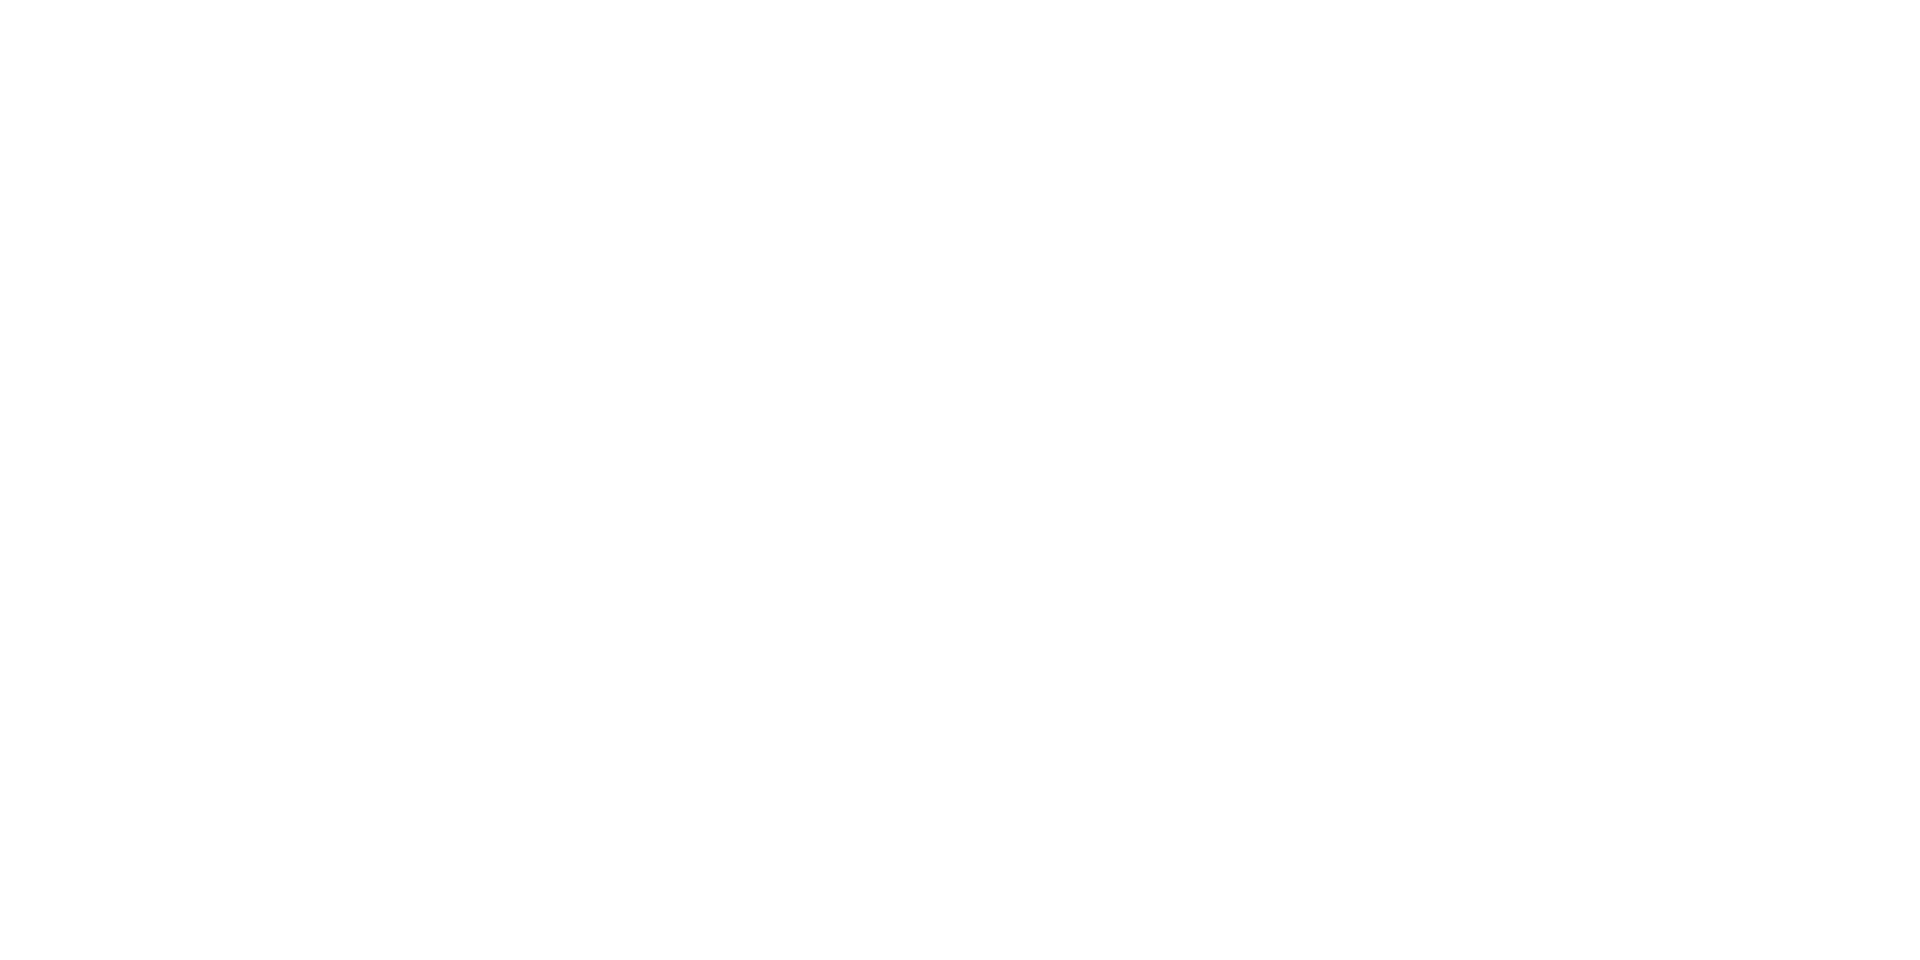

<IPython.core.display.Javascript object>


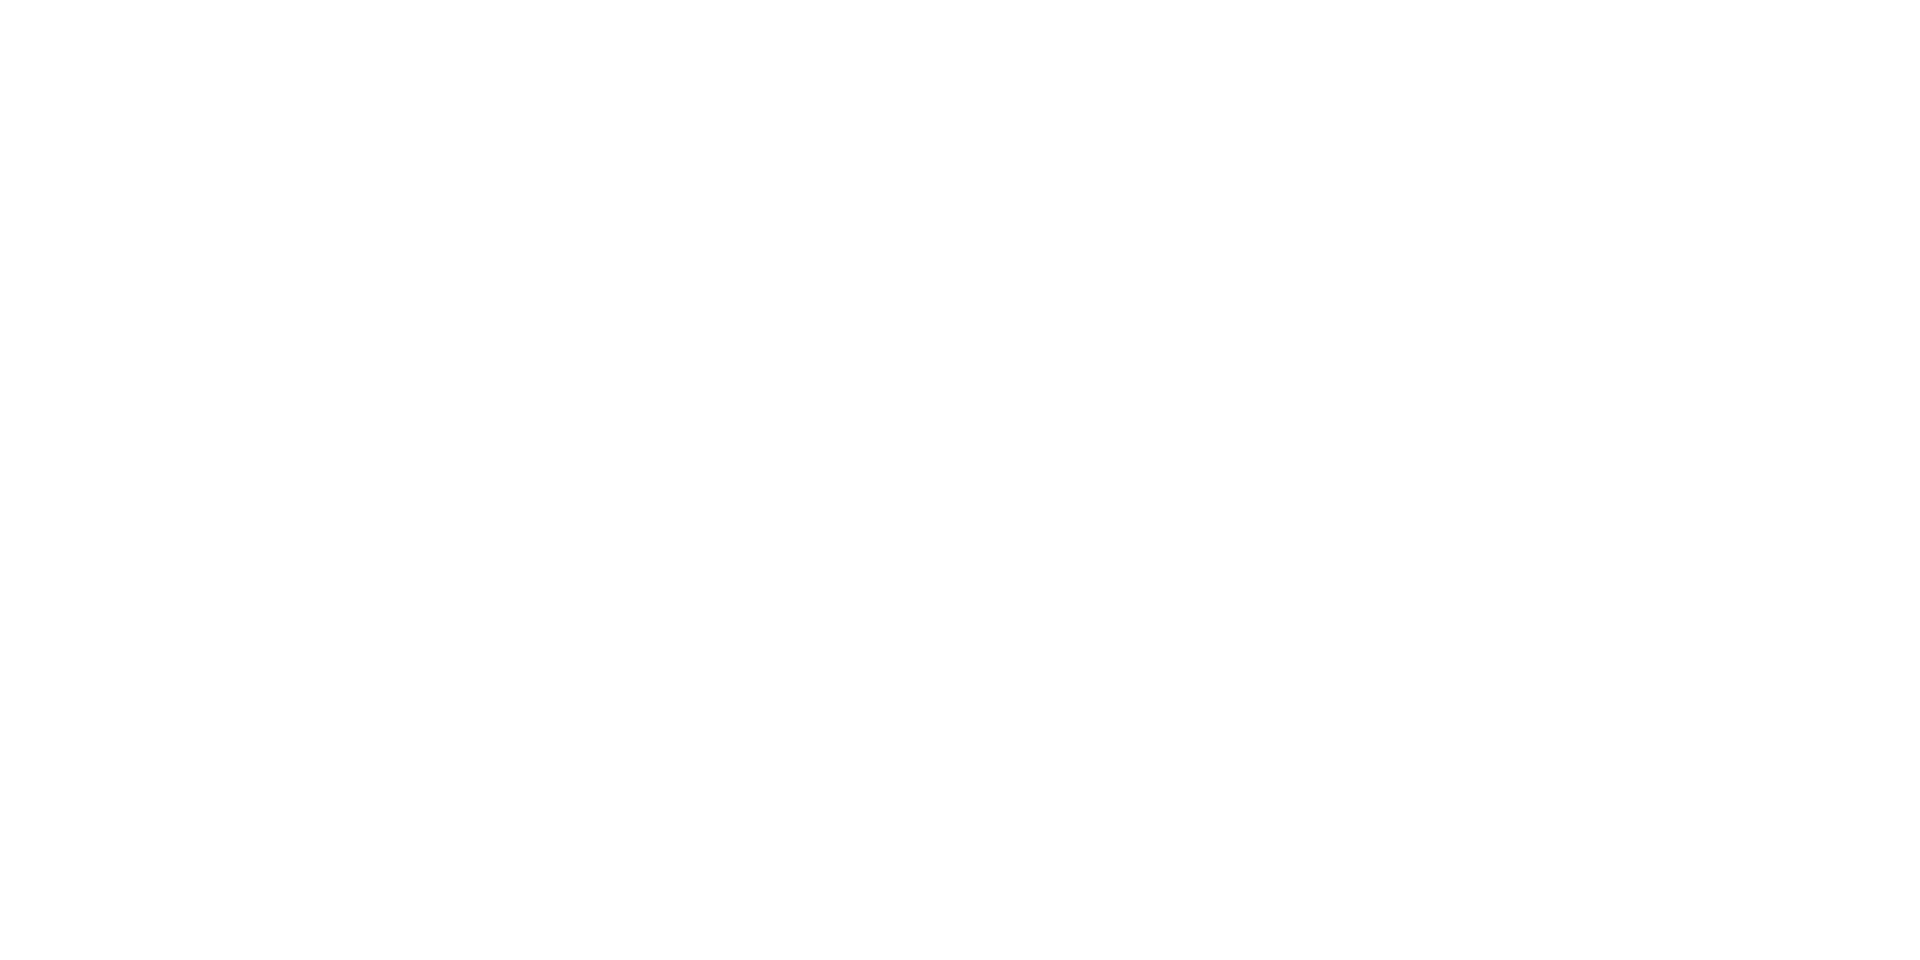

<IPython.core.display.Javascript object>


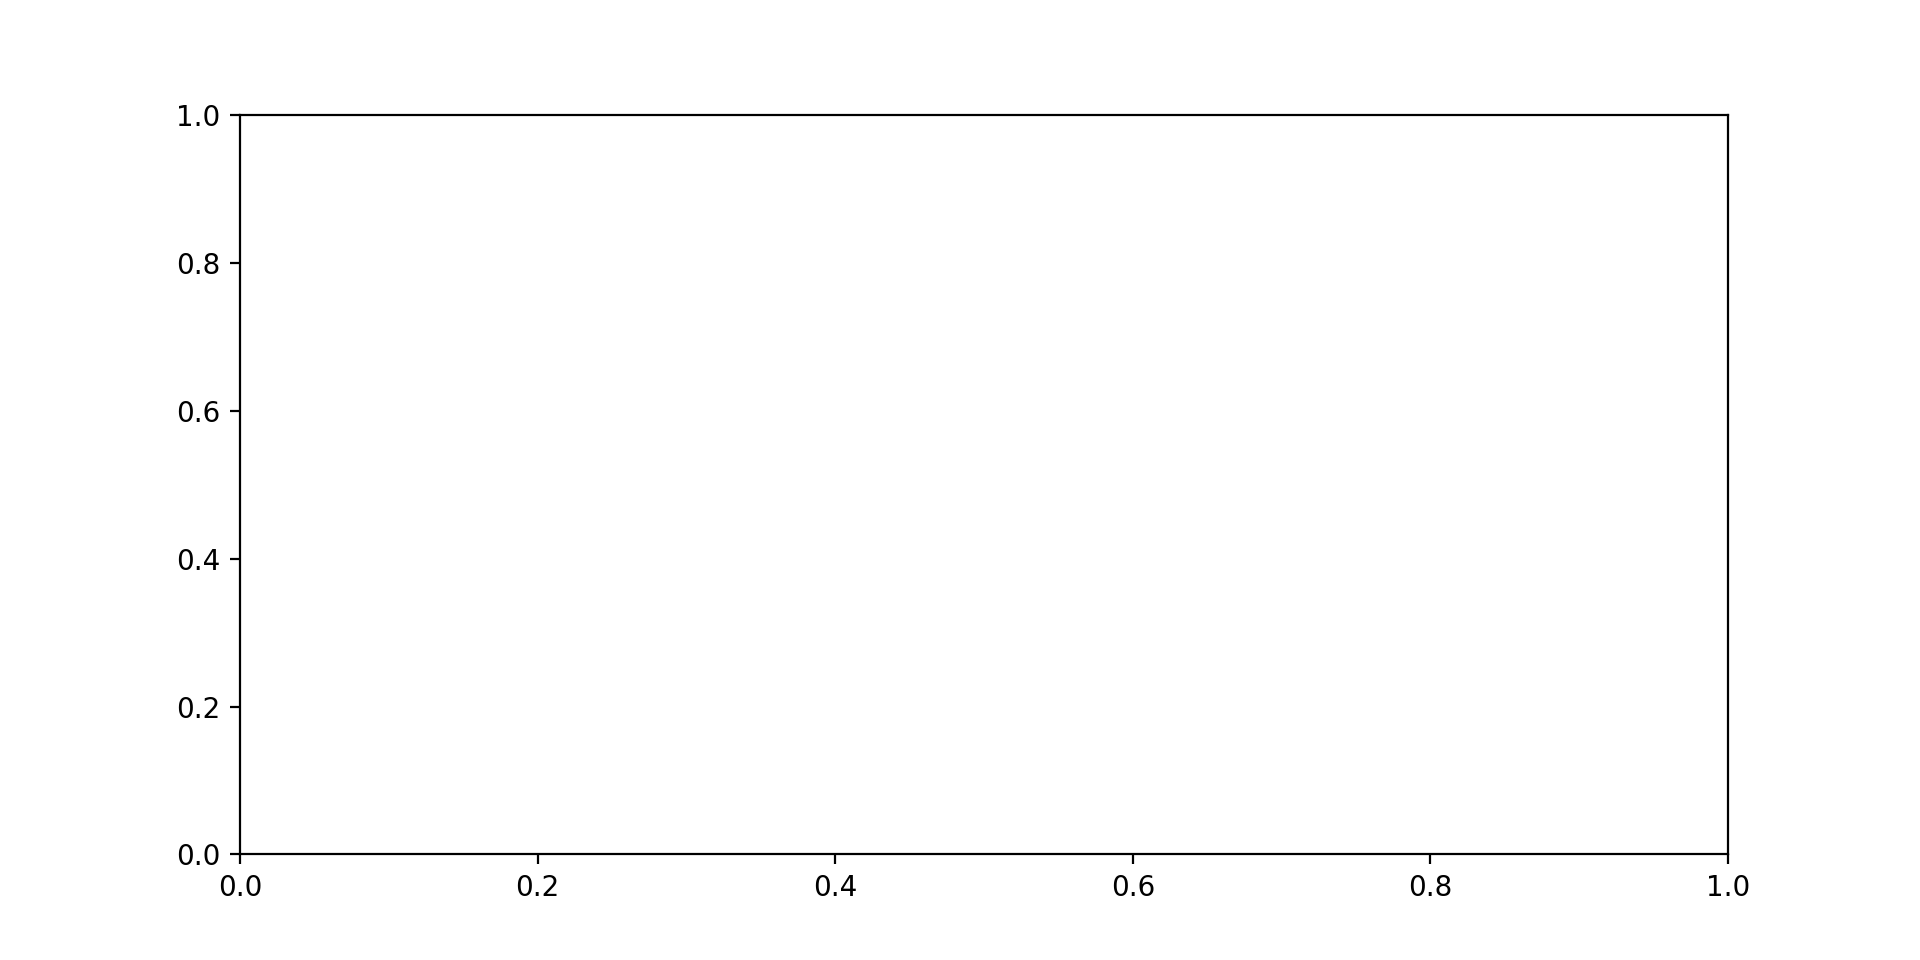

Lander Env
Landing_icgen:
    nominal_g                   :  -3.7114
    downrange                   :  (0, 2000, -70, -30)
    crossrange                  :  (-1000, 1000, -30, 30)
    altitude                    :  (2300, 2400, -90, -70)
    adjust_apf_v0               :  True
Policy
	xn_init: layer  Linear(in_features=8, out_features=80, bias=True)
	xn_init: layer  GRUCell(80, 48)
	xn_init: layer  Linear(in_features=48, out_features=30, bias=True)
	xn_init: layer  Linear(in_features=30, out_features=3, bias=True)
Policy: recurrent steps > 1, disabling shuffle
[[-1.]
 [ 0.]
 [ 1.]]
	Test Mode:          False
	Clip Param:         0.1
	Shuffle :           False
	Max Grad Norm:      30
	Recurrent Steps:    120
	Rollout Limit:      1
Value Funtion
	xn_init: layer  Linear(in_features=8, out_features=80, bias=True)
	xn_init: layer  GRUCell(80, 20)
	xn_init: layer  Linear(in_features=20, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
Value Funct

In [3]:
from env import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen2 import Landing_icgen
import rl_utils

from arch_policy_vf import Arch

from model import Model
from policy import Policy
from value_function import Value_function

import pcm_model_nets as model_nets
import policy_nets as policy_nets
import valfunc_nets as valfunc_nets

from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from reward_terminal_mdr import Reward

from dtm_measurement_model3 import DTM_measurement_model
from altimeter_v import Altimeter
dtm = np.load('../../../Mars_DTM/synth_elevations.npy')

print(dtm.shape, np.min(dtm), np.max(dtm))
target_position = np.asarray([4000,4000,400])
mm = DTM_measurement_model(dtm,check_vertical_errors=False)
altimeter =  Altimeter(mm,target_position,theta=np.pi/8)


arch = Arch()
logger = rl_utils.Logger()
dynamics_model = Dynamics_model()
lander_model = Lander_model(altimeter=altimeter, apf_tau1=20,apf_tau2=100,apf_vf1=-2,apf_vf2=-1,apf_v0=70,apf_atarg=15.)
lander_model.get_state_agent = lander_model.get_state_agent_dtm
obs_dim = 8
act_dim = 3
recurrent_steps = 120


reward_object = Reward()

glideslope_constraint = Glideslope_constraint(gs_limit=0.5)
shape_constraint = Flat_constraint()
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          tf_limit=100.0,print_every=10,scale_agent_action=True)

env.ic_gen = Landing_icgen(mass_uncertainty=0.10, 
                           g_uncertainty=(0.05,0.05),
                           adjust_apf_v0=True,
                          downrange = (0,2000 , -70, -30), 
                           crossrange = (-1000,1000 , -30,30),  
                           altitude = (2300,2400,-90,-70))

env.ic_gen.show()


arch = Arch()


policy = Policy(policy_nets.GRU(obs_dim, act_dim, recurrent_steps=recurrent_steps), shuffle=False,
                kl_targ=0.001,epochs=20, beta=0.1, servo_kl=True, max_grad_norm=30,
                init_func=rl_utils.xn_init)
value_function = Value_function(valfunc_nets.GRU(obs_dim, recurrent_steps=recurrent_steps), 
                                shuffle=False, batch_size=9999999, max_grad_norm=30)


agent = Agent(arch, policy, value_function, None, env,  logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, lam=0.98, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
load_params=True
fname = "altimeter_v_mm3-120step"
if load_params:
    policy.load_params(fname)
    value_function.load_params(fname)
else:    
    agent.train(30000)

In [10]:
fname = "altimeter_v_mm3-120step"
policy.save_params(fname)
value_function.save_params(fname)
np.save(fname + "_history",env.rl_stats.history)

# Test Policy with Realistic Noise


In [4]:
policy.test_mode=True                     
env.test_policy_batch(agent,1000,print_every=100)

DTM Model Miss Ratio:  0.0 0
i :  100
Cumulative Stats (mean,std,max,argmax)
thrust   |9635.09 |2444.39 |3464.10 |15000.00 |    38
glideslope | 2.114 | 3.112 | 0.742 |334.760 |     9
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |  27.807 |   2.849 |  24.671 |  41.004
norm_rf  |   243.9 |    75.3 |    92.7 |   676.8
position |  -121.0  -200.0    -0.7 |    71.6    73.5     0.4 |  -481.5  -475.6    -1.4 |    13.9   -49.4    -0.0
velocity |  -1.795  -3.098 -24.605 |   8.197   9.527   2.274 | -12.378 -23.837 -31.838 |  28.098  16.953 -19.390
fuel     |233.15 | 18.87 |193.67 |282.39
glideslope |  3.30 |  8.61 |  0.74 | 88.66
DTM Model Miss Ratio:  0.0 0
i :  200
Cumulative Stats (mean,std,max,argmax)
thrust   |9639.64 |2466.74 |3464.10 |15000.00 |    38
glideslope | 2.190 | 3.291 | 0.597 |339.887 |   142
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |  27.757 |   2.941 |  24.327 |  41.004
norm_rf

KeyboardInterrupt: 

In [6]:
len(lander_model.trajectory_list)
traj_list = lander_model.trajectory_list[0:100]
len(traj_list)
np.save(fname + '_100traj',traj_list)

<IPython.core.display.Javascript object>


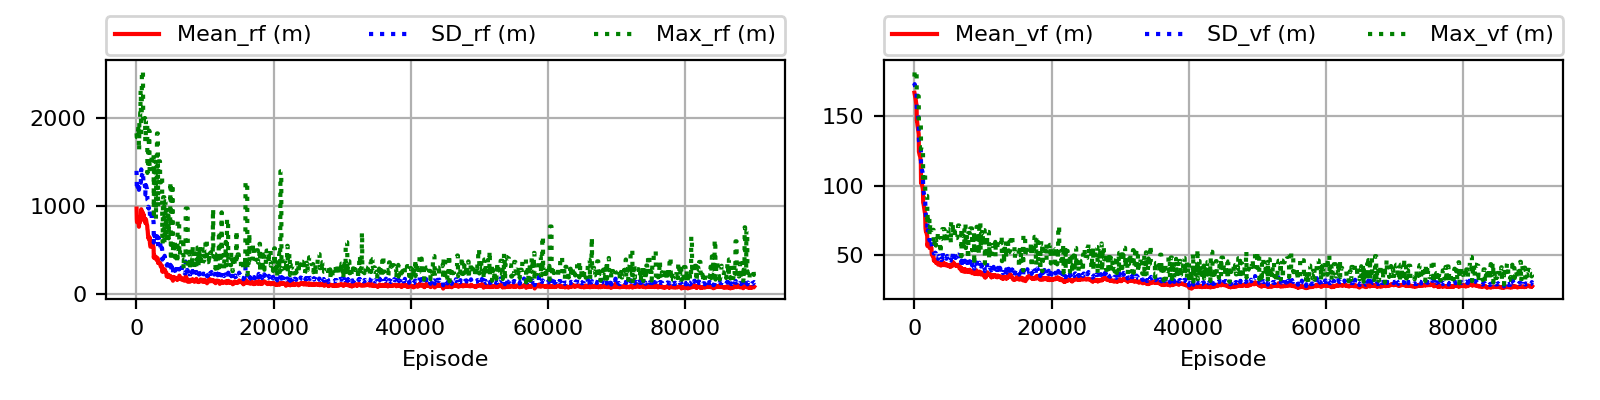

In [9]:
envu.plot_rf_vf(env.rl_stats.history)